In [1]:
import numpy as np
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph
from matplotlib import pyplot as plt
import itertools

from sklearn.metrics import normalized_mutual_info_score

In [66]:
np.random.seed(42)

In [3]:
def log_likelihood(A, pi, q, theta):
    # A : n x n
    # pi : Q
    # q : n x Q
    # theta : Q x n

    n = A.shape[0]
    Q = pi.shape[0]

    output = 0

    for i in range(n):
        for r in range(Q):
            term = 0
            term += np.log(pi[r])
            for j in range(n):
                term += A[i, j] * np.log(theta[r, j] + 1e-6)
            output += q[i, r] * term

    return output

In [4]:
def e_step(A, pi, theta):
    # A : n x n
    # pi : Q
    # theta : Q x n
    n, Q = A.shape[0], pi.shape[0]
    q = np.zeros((n, Q))
    for i in range(n):
        for r in range(Q):
            term = np.log(pi[r])
            for j in range(n):
                term *= theta[r, j]**A[i, j]
            q[i, r] = term
        q[i] = q[i] / np.sum(q[i])

    return q

In [5]:
def m_step(A, q):
    # A : n x n
    # pi : Q
    # q : n x Q
    n, Q = A.shape[0], q.shape[1]
    pi = np.zeros(Q)
    theta = np.zeros((Q, n))
    for r in range(Q):
        pi[r] = np.sum(q[:, r]) / n
        for j in range(n):
            term = 0
            for i in range(n):
                term += A[i, j] * q[i, r]
            normalizer = 0
            for i in range(n):
                k = np.sum(A[i])
                normalizer += q[i, r] * k
            theta[r, j] = term / normalizer

    return pi, theta

In [9]:
def algorithm(A, Q, max_iter=100):
    # init q randomly
    n = A.shape[0]
    q = np.random.rand(n, Q)
    q = q / np.sum(q, axis=1).reshape(-1, 1)

    previous_log_likelihood, curr_log_likelihood = None, None
    for i in range(max_iter):
        # print(q)
        pi, theta = m_step(A, q)
        q = e_step(A, pi, theta)
        previous_log_likelihood = curr_log_likelihood
        curr_log_likelihood = log_likelihood(A, pi, q, theta)
        if previous_log_likelihood is not None and curr_log_likelihood - previous_log_likelihood < 1e-5:
            break
    return q, pi, theta

# Plot functions

In [116]:
def rearrange_q(q, true_classes_clusters, Q):
    # Rearrange q such that the number of misclassified nodes is minimized

    # Store all possible permutations of the classes
    permutations = list()
    for permutation in itertools.permutations(range(Q)):
        permutations.append(permutation)

    # Compute the number of misclassified nodes for each permutation
    misclassified_nodes = list()
    for permutation in permutations:
        misclassified_nodes.append(np.sum(np.argmax(q, axis=1) != [permutation[i] for i in true_classes_clusters]))

    # Find the permutation that minimizes the number of misclassified nodes
    best_permutation = permutations[np.argmin(misclassified_nodes)]

    # Rearrange q according to the best permutation
    new_q = np.zeros_like(q)
    for i in range(Q):
        new_q[:, i] = q[:, best_permutation[i]]

    return new_q

# Karate Club Data

In [7]:
# Loads the karate network
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)

Number of nodes: 34
Number of edges: 78


In [10]:
A = nx.adjacency_matrix(G).todense()
A = np.array(A)
q, pi, theta = algorithm(A, 2)

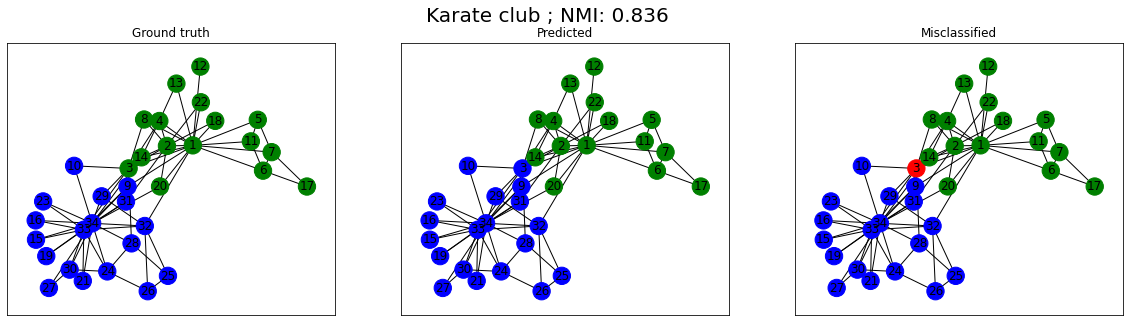

In [40]:
color_list = ['g', 'b', 'r']
fig, ax = plt.subplots(1, 3, figsize=(20 , 5))
fig.suptitle("Karate club ; NMI: {:.3f}".format(normalized_mutual_info_score(y,  np.argmax(q, axis=1))), fontsize=20)
fig.set_facecolor('w')
fig.valign = 'center'
fig.halign = 'center'
pos = nx.spring_layout(G, seed=42)
node_colors = [color_list[i] for i in y]
nx.draw_networkx(G, node_color=node_colors, ax=ax[0], pos=pos)
ax[0].set_title("Ground truth")
node_colors = np.argmax(q, axis=1)
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[1], pos=pos)
ax[1].set_title("Predicted")
node_colors = np.argmax(q, axis=1)
node_colors[node_colors != y] = 2
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[2], pos=pos)
ax[2].set_title("Misclassified")
plt.show()

# LFR Benchmarck

In [81]:
G = LFR_benchmark_graph(n=100, tau1=2, tau2=1.5, mu=0.1, average_degree=5, min_community=40, max_community=50, seed=10)
G.remove_edges_from(nx.selfloop_edges(G))

In [82]:
communities = {frozenset(G.nodes[v]["community"]) for v in G}
communities = [list(community)  for community in communities]
communities = {node: i for i, community in enumerate(communities) for node in community}

colors = ["red", "blue", "green", "yellow", "orange", "purple", "black", "pink", "brown", "cyan"]
nodes_colors = [colors[communities[node]] for node in G.nodes]

true_classes_clusters = [communities[node] for node in G.nodes]

In [83]:
A = nx.adjacency_matrix(G).todense()
A = np.array(A)
q, pi, theta = algorithm(A, 2)

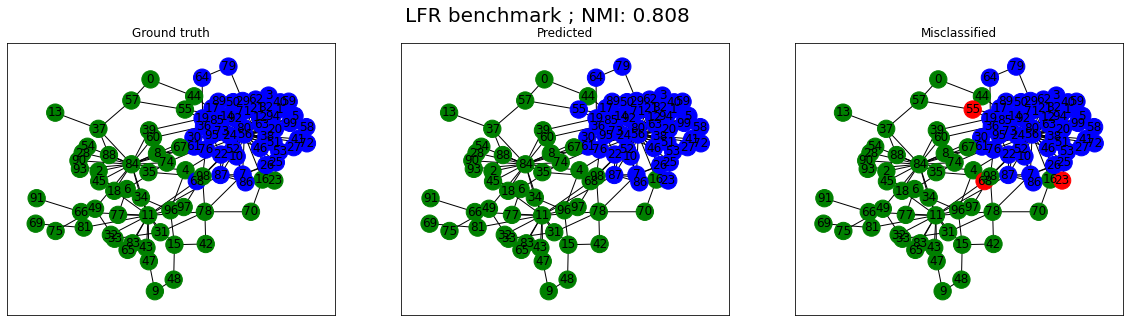

In [84]:
pos = nx.spring_layout(G, seed=42)
fig, ax = plt.subplots(1, 3, figsize=(20 , 5))
fig.suptitle("LFR benchmark ; NMI: {:.3f}".format(normalized_mutual_info_score(true_classes_clusters,  np.argmax(q, axis=1))), fontsize=20)
fig.set_facecolor('w')
fig.valign = 'center'
fig.halign = 'center'
node_colors = [color_list[i] for i in true_classes_clusters]
nx.draw_networkx(G, node_color=node_colors, ax=ax[0], pos=pos)
ax[0].set_title("Ground truth")
node_colors = np.argmax(q, axis=1)
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[1], pos=pos)
ax[1].set_title("Predicted")
node_colors = np.argmax(q, axis=1)
node_colors[node_colors != true_classes_clusters] = 2
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[2], pos=pos)
ax[2].set_title("Misclassified")
plt.show()

# Mixture model benchmark

## 2 clusters

In [95]:
from graphs import random_graph_from_parameters
from main import sort_parameters

In [100]:
# Test the algorithm on a random graph
Q = 2
n = 50
alpha = np.random.uniform(0, 0.8, Q)
alpha = alpha / np.sum(alpha)
pi = np.zeros((Q, Q))
#fill upper triangle with values between 0.1 and 0.3
for i in range(Q):
    for j in range(i+1, Q):
        pi[i][j] = round(np.random.uniform(0.1, 0.5), 2)
#make pi symmetrical
for i in range(Q):
    for j in range(i):
        pi[i][j] = pi[j][i]
#random diagonal
for i in range(Q):
    pi[i][i] = round(np.random.uniform(0.7, 1), 2)

X, Z = random_graph_from_parameters(n, Q, alpha, pi)
true_classes_clusters = np.argmax(Z, axis=1)
alpha, pi = sort_parameters(alpha, pi)

G = nx.from_numpy_array(X)

In [101]:
A = nx.adjacency_matrix(G).todense()
A = np.array(A)
q, pi, theta = algorithm(A, 2)

In [102]:
q = np.abs(1 - q)

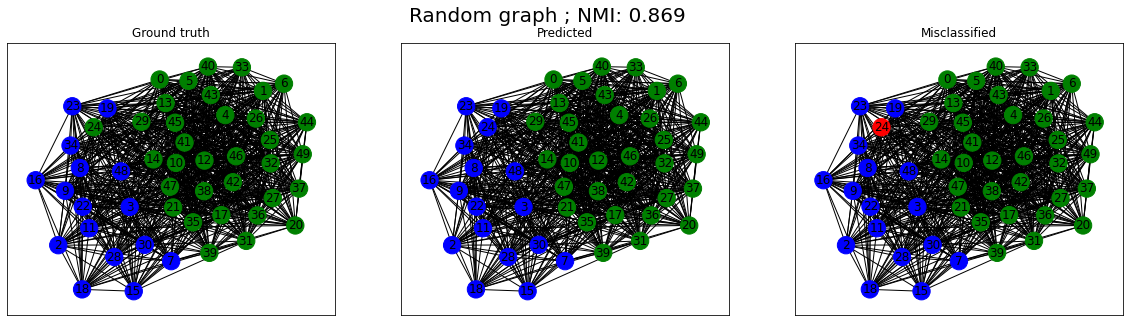

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(20 , 5))
fig.suptitle("Random graph ; NMI: {:.3f}".format(normalized_mutual_info_score(true_classes_clusters,  np.argmax(q, axis=1))), fontsize=20)
fig.set_facecolor('w')
fig.valign = 'center'
fig.halign = 'center'
pos = nx.spring_layout(G, seed=42)
node_colors = [color_list[i] for i in true_classes_clusters]
nx.draw_networkx(G, node_color=node_colors, ax=ax[0], pos=pos)
ax[0].set_title("Ground truth")
node_colors = np.argmax(q, axis=1)
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[1], pos=pos)
ax[1].set_title("Predicted")
node_colors = np.argmax(q, axis=1)
node_colors[node_colors != true_classes_clusters] = 2
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[2], pos=pos)
ax[2].set_title("Misclassified")
plt.show()

## 3 clusters

In [104]:
# Test the algorithm on a random graph
Q = 3
n = 100
alpha = np.random.uniform(0, 0.8, Q)
alpha = alpha / np.sum(alpha)
pi = np.zeros((Q, Q))
#fill upper triangle with values between 0.1 and 0.3
for i in range(Q):
    for j in range(i+1, Q):
        pi[i][j] = round(np.random.uniform(0.1, 0.5), 2)
#make pi symmetrical
for i in range(Q):
    for j in range(i):
        pi[i][j] = pi[j][i]
#random diagonal
for i in range(Q):
    pi[i][i] = round(np.random.uniform(0.7, 1), 2)

X, Z = random_graph_from_parameters(n, Q, alpha, pi)
true_classes_clusters = np.argmax(Z, axis=1)
alpha, pi = sort_parameters(alpha, pi)

G = nx.from_numpy_array(X)

In [105]:
A = nx.adjacency_matrix(G).todense()
A = np.array(A)
q, pi, theta = algorithm(A, 3)

In [114]:
q = rearrange_q(q, true_classes_clusters, Q)

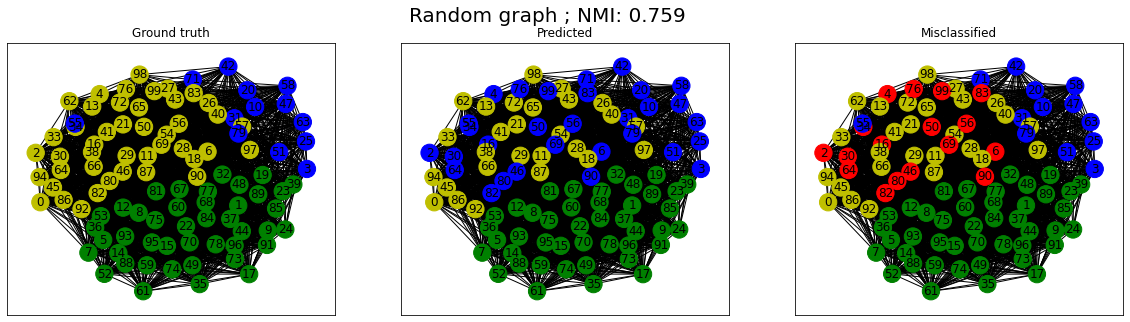

In [115]:
color_list = ['g', 'b', 'y', 'r']
fig, ax = plt.subplots(1, 3, figsize=(20 , 5))
fig.suptitle("Random graph ; NMI: {:.3f}".format(normalized_mutual_info_score(true_classes_clusters,  np.argmax(q, axis=1))), fontsize=20)
fig.set_facecolor('w')
fig.valign = 'center'
fig.halign = 'center'
pos = nx.spring_layout(G, seed=42)
node_colors = [color_list[i] for i in true_classes_clusters]
nx.draw_networkx(G, node_color=node_colors, ax=ax[0], pos=pos)
ax[0].set_title("Ground truth")
node_colors = np.argmax(q, axis=1)
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[1], pos=pos)
ax[1].set_title("Predicted")
node_colors = np.argmax(q, axis=1)
node_colors[node_colors != true_classes_clusters] = 3
node_colors = [color_list[i] for i in node_colors]
nx.draw_networkx(G, node_color=node_colors, ax=ax[2], pos=pos)
ax[2].set_title("Misclassified")
plt.show()